# Comparing Classification Performance
We are going to several classification algorithms to the loan data used in previous notebook and we will compare the results. 

As the very first step, we load all the relevant libraries.

In [1]:
# general purpose libraries libraries for tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# models
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# stat libraries
from scipy import stats

# Libraries for the evaluation
from sklearn import model_selection
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

%matplotlib inline

Then, we load the data.

In [2]:
loans = pd.read_csv('LoansNumerical.csv')

In [3]:
target = 'safe_loans'
features = loans.columns[loans.columns!=target]

The input variables x are the columns corresponding to the features, the output variable y is the column corresponding to the target variable.

In [4]:
X = loans[features]
y = loans[target]

First we apply plain logistic regression without regularization (thus $\alpha$ is zero). The Scikit-learn function does not allow to specify $\alpha$ but it uses a parameter C=1/$\alpha$. Accordingly, to have no regularization we need to specify a huge value of C. And we evaluate the model using plain crossvalidation.

In [5]:
simple_logistic = linear_model.LogisticRegression(C=10e10, random_state=0)
simple_eval = model_selection.cross_val_score(simple_logistic, X, y, cv=StratifiedKFold(n_splits=10,random_state=1234,shuffle=True))

In [6]:
print("Simple Logistic Regression\t%.1f%%\t%.1f%%" % (100.0*np.average(simple_eval), 100.0*np.std(simple_eval)))

Simple Logistic Regression	81.2%	0.1%


Next we apply naive bayes, nearest centroids, knn, and random forests.

In [7]:
nb = naive_bayes.GaussianNB();
nb_eval = model_selection.cross_val_score(nb, X, y, cv=StratifiedKFold(n_splits=10,random_state=871263,shuffle=True))

In [8]:
print("Naive Bayes\t%.1f%%\t%.1f%%" % (100.0*np.average(nb_eval), 100.0*np.std(nb_eval)))

Naive Bayes	77.3%	0.4%


In [9]:
knn = neighbors.KNeighborsClassifier(20, weights='distance')
knn_eval = model_selection.cross_val_score(knn, X, y, cv=StratifiedKFold(n_splits=10,random_state=19872,shuffle=True))

In [10]:
print("k Nearest Neighbor\t%.1f%%\t%.1f%%" % (100.0*np.average(knn_eval), 100.0*np.std(knn_eval)))

k Nearest Neighbor	80.4%	0.2%


In [11]:
rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
rf_eval = model_selection.cross_val_score(rf, X, y, cv=StratifiedKFold(n_splits=10,random_state=900234,shuffle=True))

In [12]:
print("Random Forest\t%.1f%%\t%.1f%%" % (100.0*np.average(rf_eval), 100.0*np.std(rf_eval)))

Random Forest	81.8%	0.2%


## Comparing Two Models using Unpaired t-test
Although all the models have been evaluated have been evaluated with cross-validation, we don't know whether the folds are the same. Thus for instance we don't know if the first element in the evaluation array was measured on the same fold over all the algorithms. Accordingly, we need to apply unpaired t-Test.

Let's compare the performance of Logistic Regression vs Random Forests.

In [19]:
def PrintSignificance(stat, c):
    if (stat[1]<(1-c)):
        print("The difference is statistically significant (cf %3.2f p-value=%.4f)"%(c,stat[1]))
    else:
        print("The difference is not statistically significant (cf %3.2f p-value=%.4f)"%(c,stat[1]))        

In [20]:
unpaired_lr_rf = stats.ttest_ind(simple_eval, rf_eval)
print("Logistic Regression vs Random Forests: p-value = %4.3f"%unpaired_lr_rf[1])
PrintSignificance(unpaired_lr_rf, 0.95)
print("\n")

unpaired_lr_nb = stats.ttest_ind(simple_eval, nb_eval)
print("Logistic Regression vs Naive Bayes: p-value = %4.3f"%unpaired_lr_nb[1])
PrintSignificance(unpaired_lr_nb, 0.95)
print("\n")

unpaired_rf_nb = stats.ttest_ind(rf_eval, nb_eval)
print("Random Forests vs Naive Bayes: p-value = %4.3f"%unpaired_rf_nb[1])
PrintSignificance(unpaired_lr_nb, 0.95)
print("\n")

unpaired_rf_knn = stats.ttest_ind(rf_eval, knn_eval)
print("Random Forests vs KNN: p-value = %4.3f"%unpaired_rf_knn[1])
PrintSignificance(unpaired_lr_nb, 0.95)

Logistic Regression vs Random Forests: p-value = 0.000
The difference is statistically significant (cf 0.95 p-value=0.0000)


Logistic Regression vs Naive Bayes: p-value = 0.000
The difference is statistically significant (cf 0.95 p-value=0.0000)


Random Forests vs Naive Bayes: p-value = 0.000
The difference is statistically significant (cf 0.95 p-value=0.0000)


Random Forests vs KNN: p-value = 0.000
The difference is statistically significant (cf 0.95 p-value=0.0000)


Should we use the Bonferroni correction? If yes, how would you change your confidence level? We are using a 95% confidence level so $\alpha$ is 0.05 (that is, 1-0.95). We are making three comparisons so the new $\alpha$ should be 0.05/4

Let's repeat the test using non-parametric tests like Mann-Whitney U Test

In [21]:
non_par_rf_knn = stats.mannwhitneyu(simple_eval, rf_eval)
PrintSignificance(non_par_rf_knn,0.95)

The difference is statistically significant (cf 0.95 p-value=0.0001)


Also the non parametric tests confirm the previous results.

## Comparing Two Models using Accuracy and Paired t-Test
We compare k-nearest-neighbor and random forests using the same folds.

In [24]:
# Generate the train/test indexes for the folds we are going to use
tf = model_selection.StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

lr_scores = []
rf_scores = []

for train, test in tf.split(X,y):
    l = loans.loc[train]
    train_x = l[features]
    train_y = l[target]
    
    l_test = loans.loc[test]
    test_x = l_test[features]
    test_y = l_test[target]
    
    lr = linear_model.LogisticRegression(C=10e10, random_state=0)
    lr = lr.fit(train_x, train_y)
    acc_lr = accuracy_score(test_y, lr.predict(test_x))

    rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
    rf = rf.fit(train_x, train_y)
    acc_rf = accuracy_score(test_y, rf.predict(test_x))
    
    print("Logistic Regression %3.1f\tRandom Forest %3.1f"%(acc_lr*100.0,acc_rf*100.0))
    
    lr_scores.append(acc_lr) # = knn_scores + [acc_knn]
    rf_scores.append(acc_rf)

Logistic Regression 81.2	Random Forest 81.7
Logistic Regression 81.1	Random Forest 81.6
Logistic Regression 81.4	Random Forest 82.1
Logistic Regression 81.4	Random Forest 82.0
Logistic Regression 81.4	Random Forest 81.8
Logistic Regression 81.3	Random Forest 81.6
Logistic Regression 81.3	Random Forest 81.9
Logistic Regression 81.2	Random Forest 81.9
Logistic Regression 81.3	Random Forest 81.8
Logistic Regression 81.4	Random Forest 82.0


In [29]:
print("Logistic Regression\t%.1f\t%.1f" % (100.0*np.average(lr_scores), 100.0*np.std(lr_scores)))
print("Random Forest      \t%.1f\t%.1f" % (100.0*np.average(rf_scores), 100.0*np.std(rf_scores)))

Logistic Regression	81.3	0.1
Random Forest      	81.8	0.2


In [33]:
paired_test = stats.ttest_rel(lr_scores, rf_scores)
print("Logistic Regression vs Random Forests (Paired t-test)")
PrintSignificance(paired_test, 0.95)

wilcoxon_test = stats.wilcoxon(lr_scores, rf_scores)
print("Logistic Regression vs Random Forests (Wilcoxon)")
PrintSignificance(wilcoxon_test, 0.95)

Logistic Regression vs Random Forests (Paired t-test)
The difference is statistically significant (cf 0.95 p-value=0.0000)
Logistic Regression vs Random Forests (Wilcoxon)
The difference is statistically significant (cf 0.95 p-value=0.0051)


## Comparing Two Models using F1 and Paired t-Test
To perform the same comparisong using a custom evaluation function (e.g. F1) we need to substitute the lines

    acc_lr = accuracy_score(test_y, lr.predict(test_x))
    acc_rf = accuracy_score(test_y, rf.predict(test_x))

With the custom evaluation like for instance, 

    f1_lr = f1_score(test_y, lr.predict(test_x))
    f1_rf = f1_score(test_y, rf.predict(test_x))

In [41]:
# Generate the train/test indexes for the folds we are going to use
tf = model_selection.StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

lr_f1_scores = []
rf_f1_scores = []

for train, test in tf.split(X,y):
    l = loans.loc[train]
    train_x = l[features]
    train_y = l[target]
    
    l_test = loans.loc[test]
    test_x = l_test[features]
    test_y = l_test[target]
    
    lr = linear_model.LogisticRegression(C=10e10, random_state=0)
    lr = lr.fit(train_x, train_y)
    f1_lr = f1_score(test_y, lr.predict(test_x))

    rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
    rf = rf.fit(train_x, train_y)
    f1_rf = f1_score(test_y, rf.predict(test_x))
    
    print("F1 Logistic Regression %3.1f\tRandom Forest %3.1f"%(f1_lr*100.0,f1_rf*100.0))
    
    lr_f1_scores.append(f1_lr) # = knn_scores + [acc_knn]
    rf_f1_scores.append(f1_rf)

F1 Logistic Regression 89.6	Random Forest 89.7
F1 Logistic Regression 89.6	Random Forest 89.5
F1 Logistic Regression 89.6	Random Forest 89.8
F1 Logistic Regression 89.6	Random Forest 89.7
F1 Logistic Regression 89.6	Random Forest 89.7
F1 Logistic Regression 89.6	Random Forest 89.6
F1 Logistic Regression 89.6	Random Forest 89.7
F1 Logistic Regression 89.6	Random Forest 89.7
F1 Logistic Regression 89.6	Random Forest 89.6
F1 Logistic Regression 89.7	Random Forest 89.8


In [43]:
print("Logistic Regression F1\t%.1f\t%.1f" % (100.0*np.average(lr_f1_scores), 100.0*np.std(lr_f1_scores)))
print("Random Forest       F1\t%.1f\t%.1f" % (100.0*np.average(rf_f1_scores), 100.0*np.std(rf_f1_scores)))

Logistic Regression F1	89.6	0.0
Random Forest       F1	89.7	0.1


In [46]:
paired_test = stats.ttest_rel(lr_f1_scores, rf_f1_scores)
print("Logistic Regression vs Random Forests (Paired t-test)")
PrintSignificance(paired_test, 0.95)

wilcoxon_test = stats.wilcoxon(lr_f1_scores, rf_f1_scores)
print("Logistic Regression vs Random Forests (Wilcoxon)")
PrintSignificance(wilcoxon_test, 0.95)

Logistic Regression vs Random Forests (Paired t-test)
The difference is statistically significant (cf 0.95 p-value=0.0114)
Logistic Regression vs Random Forests (Wilcoxon)
The difference is statistically significant (cf 0.95 p-value=0.0125)


## Receiver Operating Characteristic (ROC) Curves
We now plot the ROC curve for Logistic Regression and Naive Bayes

In [55]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

simple_logistic = linear_model.LogisticRegression(C=10e10, random_state=0)
simple_eval = simple_logistic.fit(train_x, train_y)
lr_pred = simple_logistic.predict(test_x);
lr_acc = accuracy_score(y_true=test_y, y_pred=lr_pred)

nb = naive_bayes.GaussianNB();
nb_eval = nb.fit(train_x, train_y)
nb_pred = nb.predict(test_x)
nb_acc = accuracy_score(y_true=test_y, y_pred=nb_pred)

rf = RandomForestClassifier(n_estimators=40, max_depth=None, min_samples_split=2, random_state=0)
rf_eval = rf.fit(train_x, train_y)
rf_pred = rf.predict(test_x)
rf_acc = accuracy_score(y_true=test_y, y_pred=rf_pred)

knn = neighbors.KNeighborsClassifier(20, weights='distance')
knn_eval = knn.fit(train_x, train_y)
knn_pred = knn.predict(test_x)
knn_acc = accuracy_score(y_true=test_y, y_pred=knn_pred)

In [56]:
print("Logistic Regression\t%.1f%%" % (100.0*lr_acc))
print("Naive Bayes        \t%.1f%%" % (100.0*nb_acc))
print("Random Forest      \t%.1f%%" % (100.0*rf_acc))
print("KNN                \t%.1f%%" % (100.0*knn_acc))

Logistic Regression	81.1%
Naive Bayes        	77.6%
Random Forest      	81.8%
KNN                	80.2%


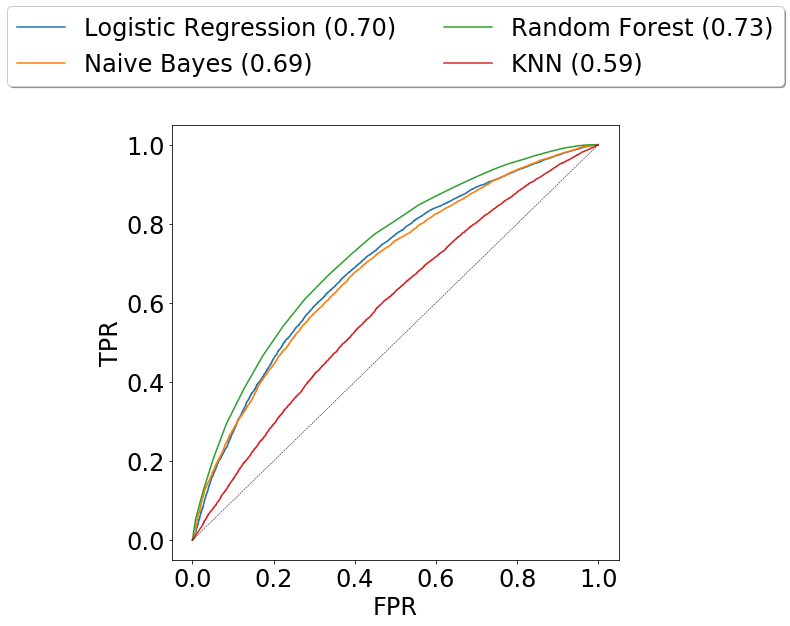

In [79]:
lr_prob = simple_eval.predict_proba(test_x)
nb_prob = nb_eval.predict_proba(test_x)
rf_prob = rf_eval.predict_proba(test_x)
knn_prob = knn_eval.predict_proba(test_x)

fpr, tpr, thresholds = roc_curve(y_true=test_y, y_score = lr_prob[:,1], pos_label=1)
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_true=test_y, y_score = nb_prob[:,1], pos_label=1)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true=test_y, y_score = rf_prob[:,1], pos_label=1)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_true=test_y, y_score = knn_prob[:,1], pos_label=1)

lr_roc_auc = roc_auc_score(y_true=test_y, y_score = lr_prob[:,1])
nb_roc_auc = roc_auc_score(y_true=test_y, y_score = nb_prob[:,1])
rf_roc_auc = roc_auc_score(y_true=test_y, y_score = rf_prob[:,1])
knn_roc_auc = roc_auc_score(y_true=test_y, y_score = knn_prob[:,1])




plt.figure(1, figsize=(8, 8));
font = {'family':'sans', 'size':24};
plt.rc('font', **font);
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.plot(fpr,tpr,label='Logistic Regression (%3.2f)'%lr_roc_auc)
plt.plot(fpr_nb,tpr_nb,label='Naive Bayes (%3.2f)'%nb_roc_auc)
plt.plot(fpr_rf,tpr_rf,label='Random Forest (%3.2f)'%rf_roc_auc)
plt.plot(fpr_knn,tpr_knn,label='KNN (%3.2f)'%knn_roc_auc)
plt.plot([0.0,1.0],[0.0,1.0],color='black',ls='--',lw=.5)
plt.yticks(np.arange(0.0,1.01,.2))
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
           ncol=2, fancybox=True, shadow=True)
plt.show();

So while accuracy is quite different (almost four percentage points) the AUC for Logistic Regression and Naive Bayes is quite similar. This is not surprising as the two metrics measures different aspects of performance. The ROC curve shows that the two approaches behave similarly when it comes to TPR and FPR. Random forests perform better both as accuracy and AUC.